<a href="https://colab.research.google.com/github/bida22-070/BIDA22-070/blob/main/Week7_Machine_Learning_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Environment Setup and Imports
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_curve, roc_auc_score,
                           precision_recall_curve)
from sklearn.datasets import load_breast_cancer, load_iris

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print("Dataset Information:")
print(f"Shape of features: {X.shape}")
print(f"Shape of target: {y.shape}")
print(f"Feature names: {len(feature_names)}")
print(f"Target names: {target_names}")
print(f"Class distribution: {np.bincount(y)}")

Dataset Information:
Shape of features: (569, 30)
Shape of target: (569,)
Feature names: 30
Target names: ['malignant' 'benign']
Class distribution: [212 357]


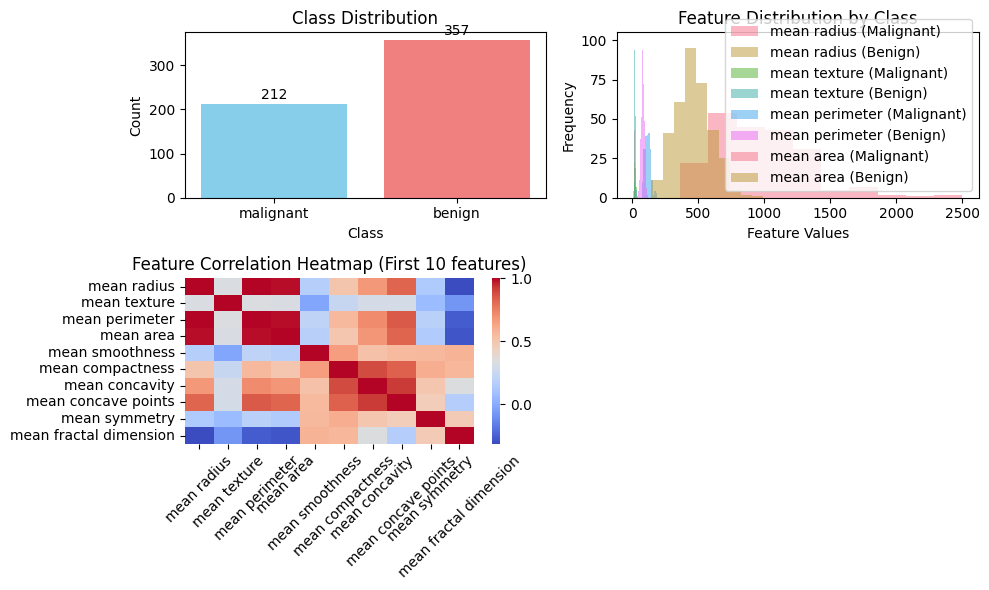

In [3]:
# Class distribution visualization
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.bar(target_names, np.bincount(y), color=['skyblue', 'lightcoral'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
for i, count in enumerate(np.bincount(y)):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Feature distribution for some important features
plt.subplot(2, 2, 2)
important_features = [0, 1, 2, 3]  # First few features
for i in important_features:
    plt.hist(X[y == 0, i], alpha=0.5, label=f'{feature_names[i]} (Malignant)')
    plt.hist(X[y == 1, i], alpha=0.5, label=f'{feature_names[i]} (Benign)')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.title('Feature Distribution by Class')
plt.legend()

# Correlation heatmap for first 10 features
plt.subplot(2, 2, 3)
correlation_matrix = np.corrcoef(X[:, :10], rowvar=False)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',
            xticklabels=feature_names[:10], yticklabels=feature_names[:10])
plt.title('Feature Correlation Heatmap (First 10 features)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [4]:
#Data preprocessing and Model training pipeline
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """Train and evaluate a classification model"""

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=target_names)

    # ROC curve data if probabilities are available
    roc_auc = None
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }

def plot_model_comparisons(results):
    """Plot comparison of different models"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Accuracy comparison
    model_names = [result['name'] for result in results]
    accuracies = [result['accuracy'] for result in results]

    axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    for i, acc in enumerate(accuracies):
        axes[0, 0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

    # Confusion matrices
    for i, result in enumerate(results):
        row, col = (i + 1) // 2, (i + 1) % 2
        conf_matrix = result['confusion_matrix']
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=target_names, yticklabels=target_names, ax=axes[row, col])
        axes[row, col].set_title(f'{result["name"]} - Confusion Matrix')
        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(10, 8))
    for result in results:
        if result['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            auc_score = result['roc_auc']
            plt.plot(fpr, tpr, label=f'{result["name"]} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
#Main training pipeline for Breast Cancer dataset
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split information:")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Data split information:
Training set size: (455, 30)
Test set size: (114, 30)
Training class distribution: [170 285]
Test class distribution: [42 72]


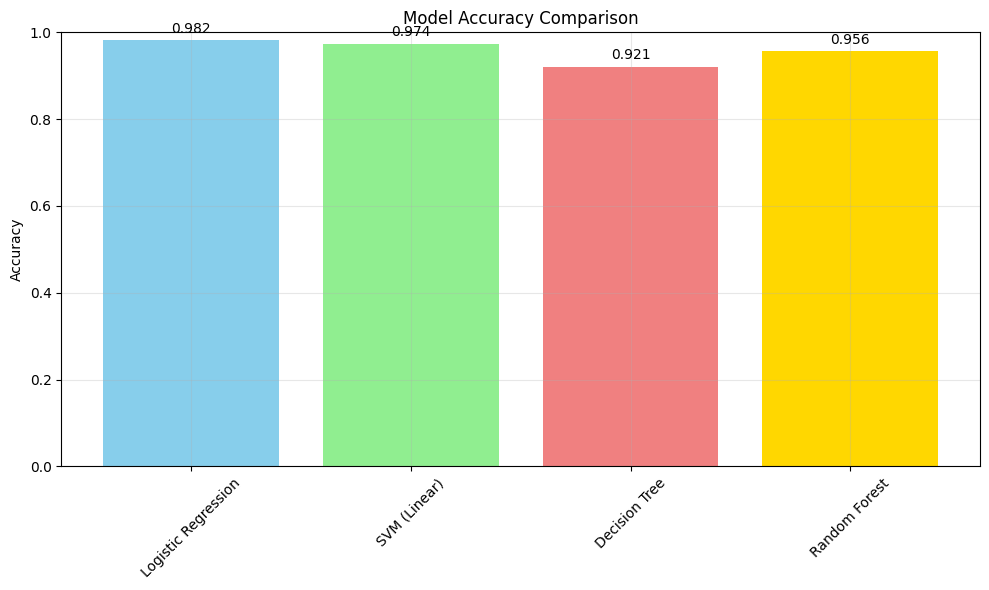

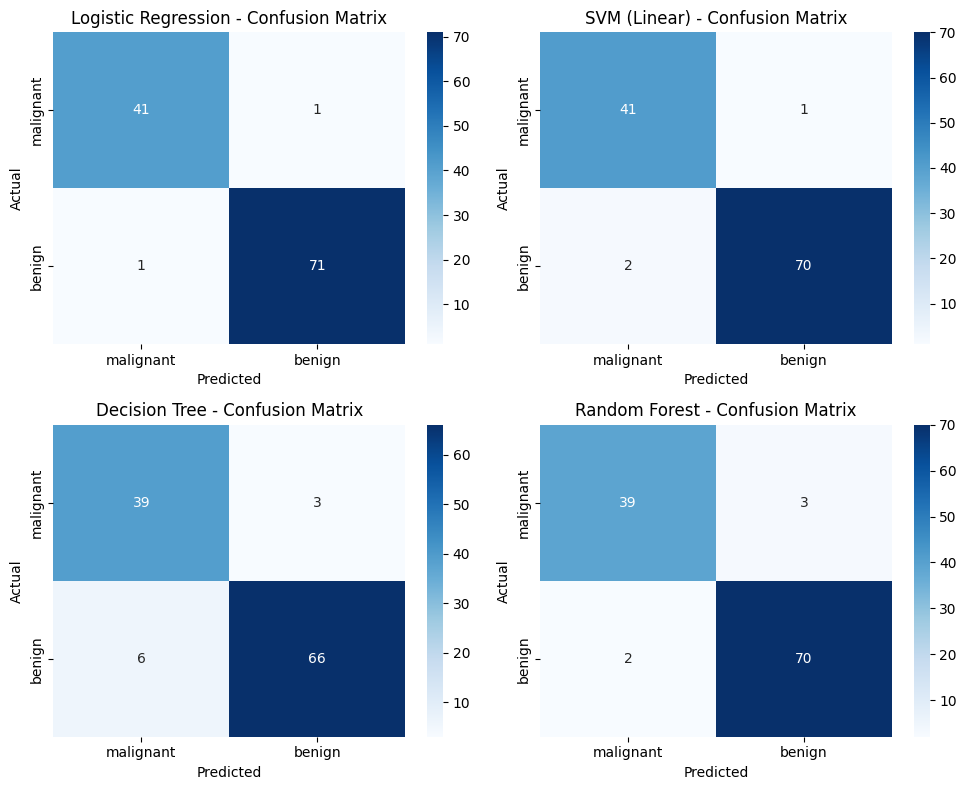

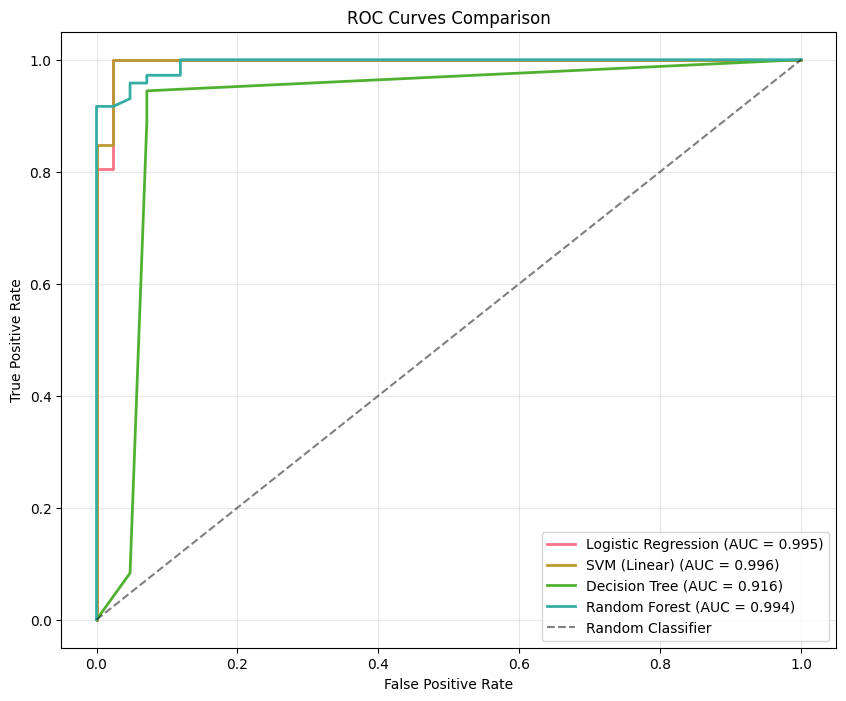

In [8]:
#Train multiple classifiers
def plot_model_comparisons_simple(results):
    """Simplified version that creates separate plots"""

    # Plot 1: Accuracy comparison
    plt.figure(figsize=(10, 6))
    model_names = [result['name'] for result in results]
    accuracies = [result['accuracy'] for result in results]

    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Confusion matrices in a grid
    n_models = len(results)
    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    # Handle case when there's only one row
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, result in enumerate(results):
        if i < len(axes):
            conf_matrix = result['confusion_matrix']
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                       xticklabels=target_names, yticklabels=target_names, ax=axes[i])
            axes[i].set_title(f'{result["name"]} - Confusion Matrix')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

    # Hide any unused subplots
    for i in range(len(results), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Plot 3: ROC curves
    plt.figure(figsize=(10, 8))
    for result in results:
        if result['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            auc_score = result['roc_auc']
            plt.plot(fpr, tpr, label=f'{result["name"]} (AUC = {auc_score:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Use the simplified version
plot_model_comparisons_simple(results)

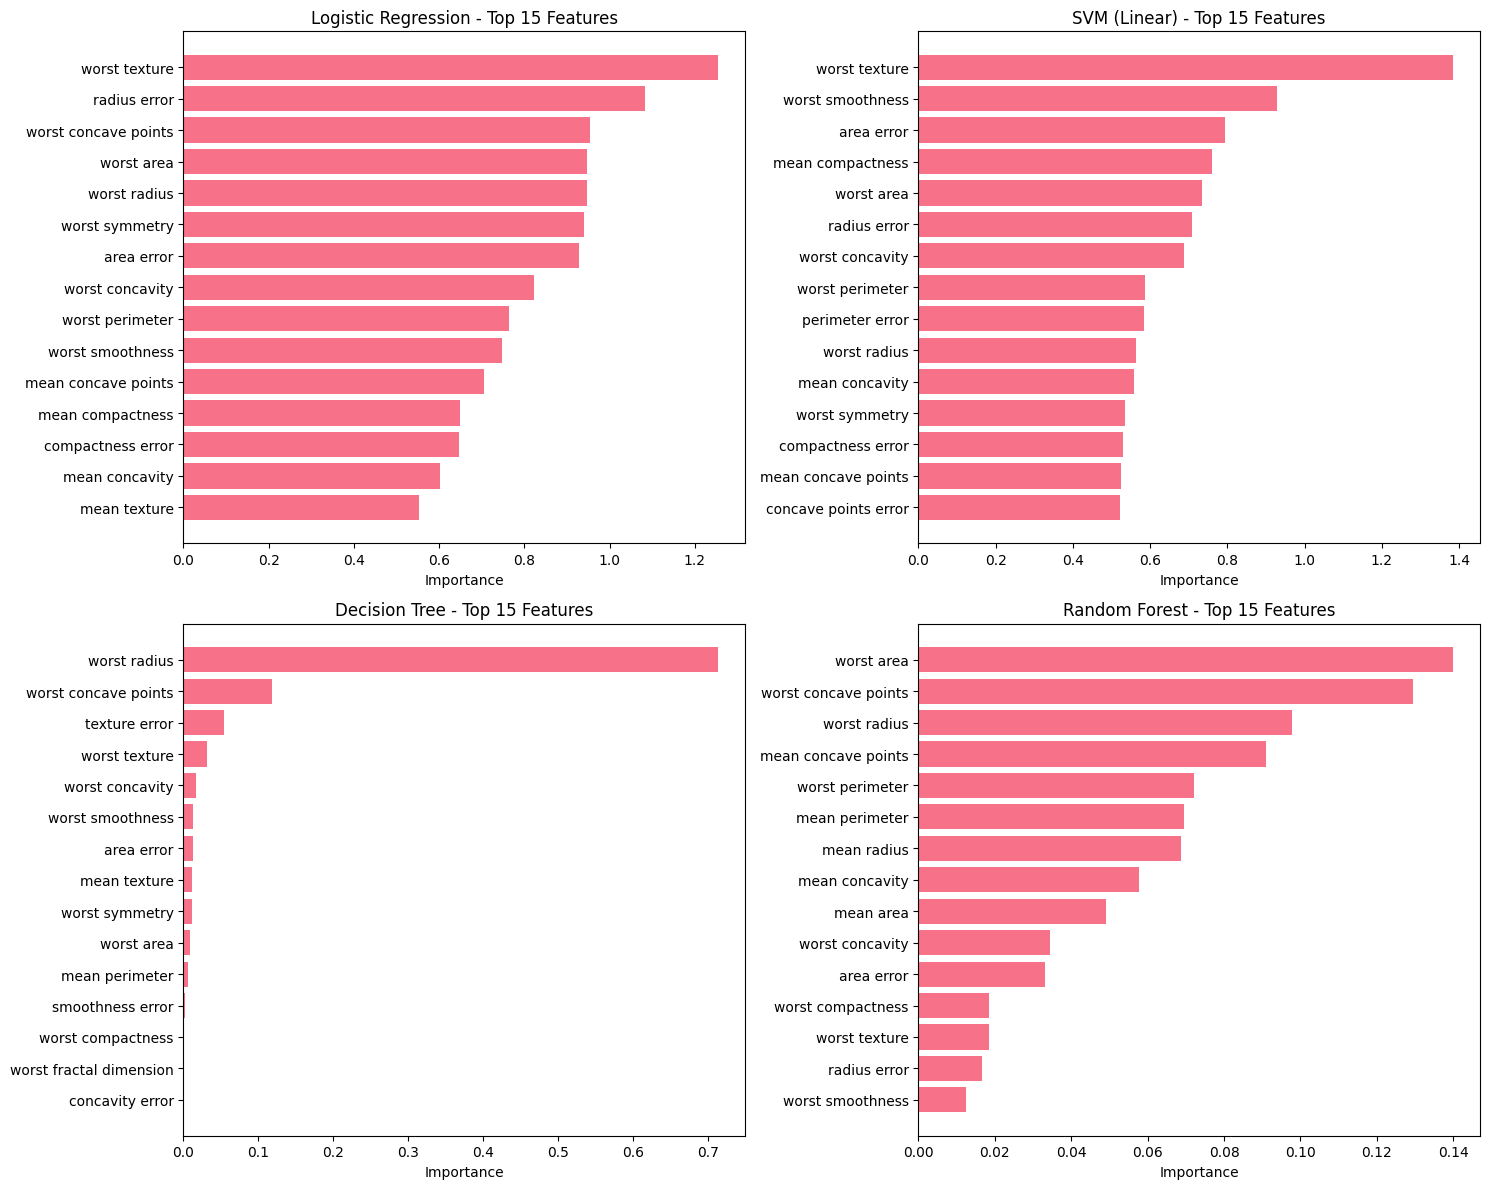

In [9]:
def plot_feature_importance(results, feature_names, top_n=15):
    """Plot feature importance from different models"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, result in enumerate(results):
        model = result['model']
        model_name = result['name']

        # Get feature importance based on model type
        if hasattr(model, 'coef_'):
            # Logistic Regression, SVM
            importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            # Tree-based models
            importance = model.feature_importances_
        else:
            continue

        # Sort features by importance
        sorted_idx = np.argsort(importance)[-top_n:]

        axes[i].barh(range(len(sorted_idx)), importance[sorted_idx])
        axes[i].set_yticks(range(len(sorted_idx)))
        axes[i].set_yticklabels([feature_names[j] for j in sorted_idx])
        axes[i].set_title(f'{model_name} - Top {top_n} Features')
        axes[i].set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(results, feature_names)


IRIS DATASET ANALYSIS
Shape of features: (150, 4)
Shape of target: (150,)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']
Class distribution: [50 50 50]


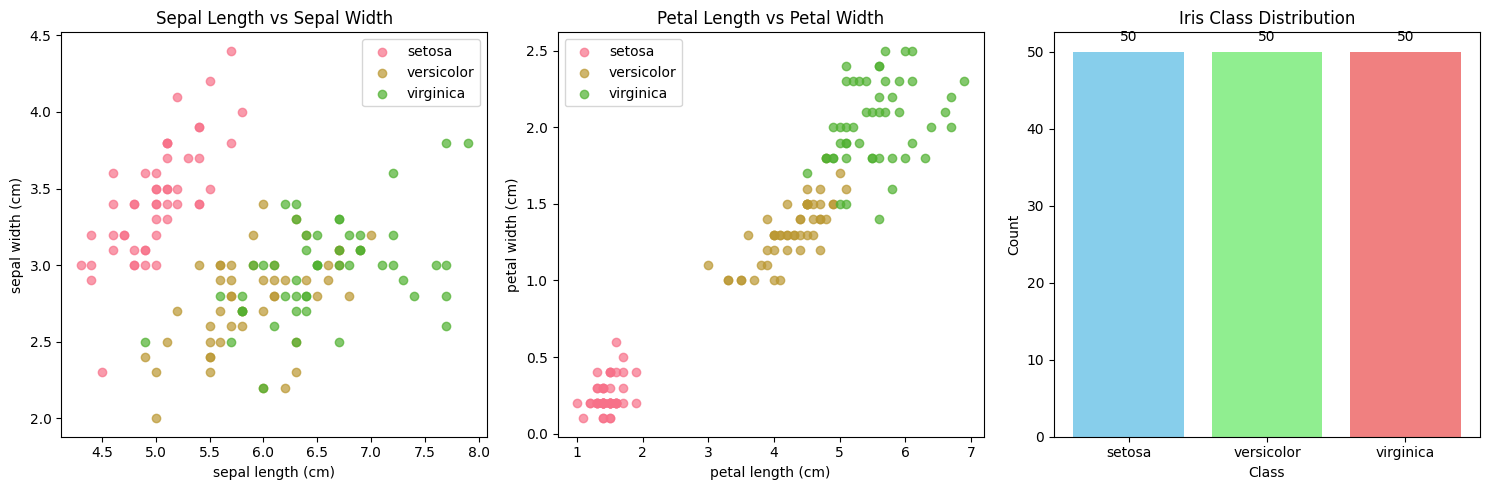

In [10]:
# Load iris dataset
iris_data = load_iris()
X_iris = iris_data.data
y_iris = iris_data.target
iris_feature_names = iris_data.feature_names
iris_target_names = iris_data.target_names

print("\n" + "="*60)
print("IRIS DATASET ANALYSIS")
print("="*60)
print(f"Shape of features: {X_iris.shape}")
print(f"Shape of target: {y_iris.shape}")
print(f"Feature names: {iris_feature_names}")
print(f"Target names: {iris_target_names}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Visualize iris dataset
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for i in range(len(iris_target_names)):
    plt.scatter(X_iris[y_iris == i, 0], X_iris[y_iris == i, 1],
               label=iris_target_names[i], alpha=0.7)
plt.xlabel(iris_feature_names[0])
plt.ylabel(iris_feature_names[1])
plt.legend()
plt.title('Sepal Length vs Sepal Width')

plt.subplot(1, 3, 2)
for i in range(len(iris_target_names)):
    plt.scatter(X_iris[y_iris == i, 2], X_iris[y_iris == i, 3],
               label=iris_target_names[i], alpha=0.7)
plt.xlabel(iris_feature_names[2])
plt.ylabel(iris_feature_names[3])
plt.legend()
plt.title('Petal Length vs Petal Width')

plt.subplot(1, 3, 3)
class_counts = np.bincount(y_iris)
plt.bar(iris_target_names, class_counts, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Iris Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(class_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Training Logistic Regression on Iris dataset...
Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


Training SVM (RBF) on Iris dataset...
Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Training Decision Tree on Iris dataset...
Accuracy: 0.9667

Classif

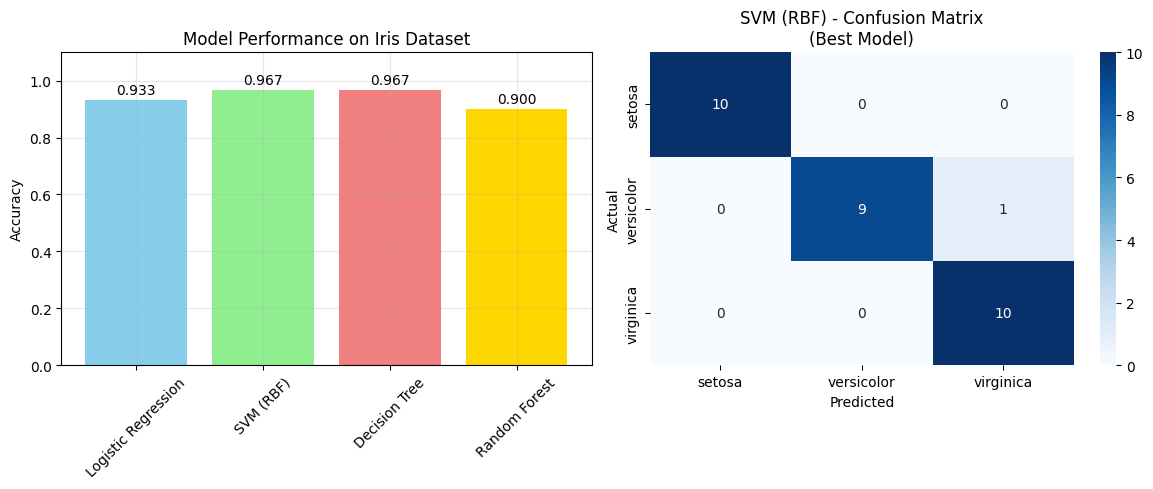

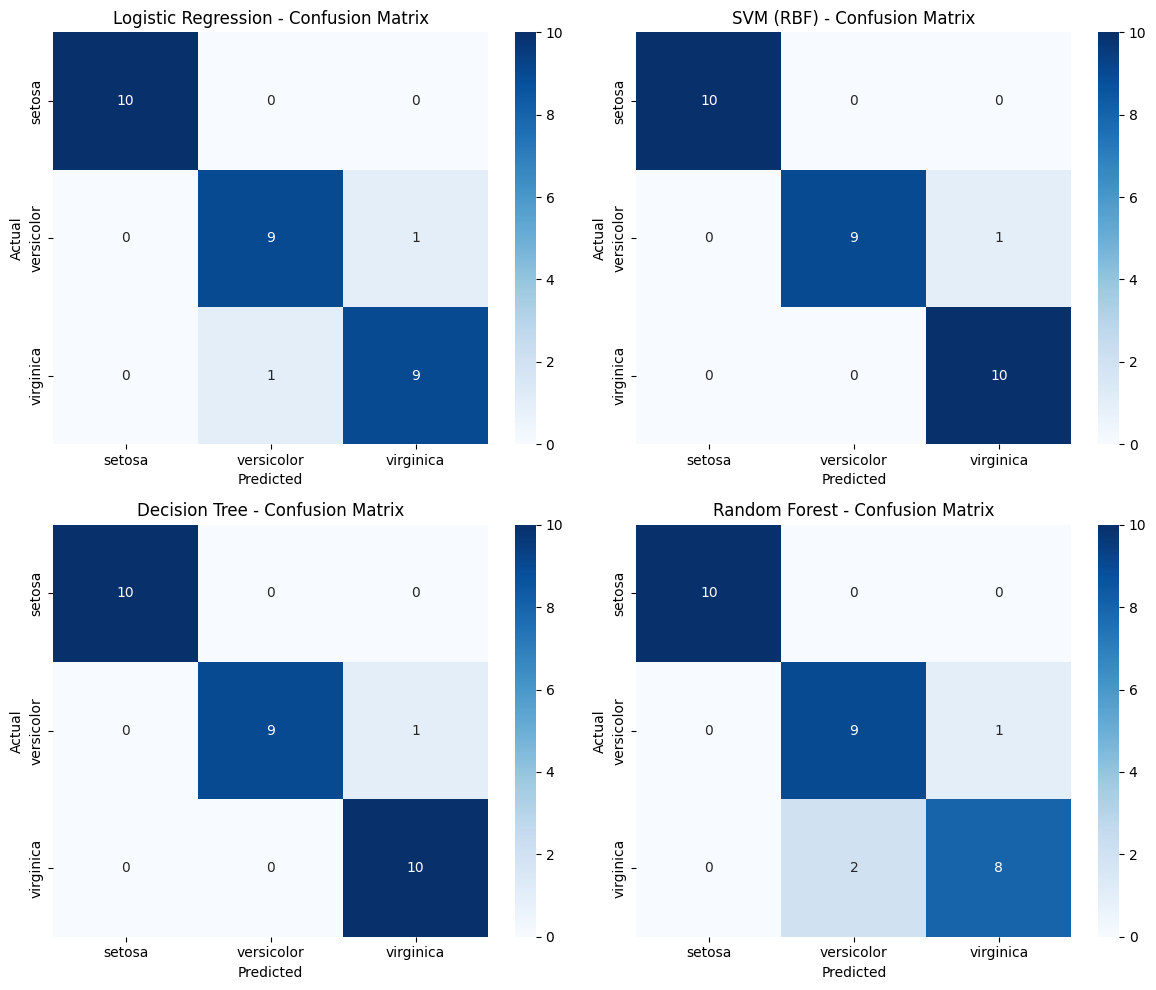


IRIS DATASET - ADDITIONAL ANALYSIS


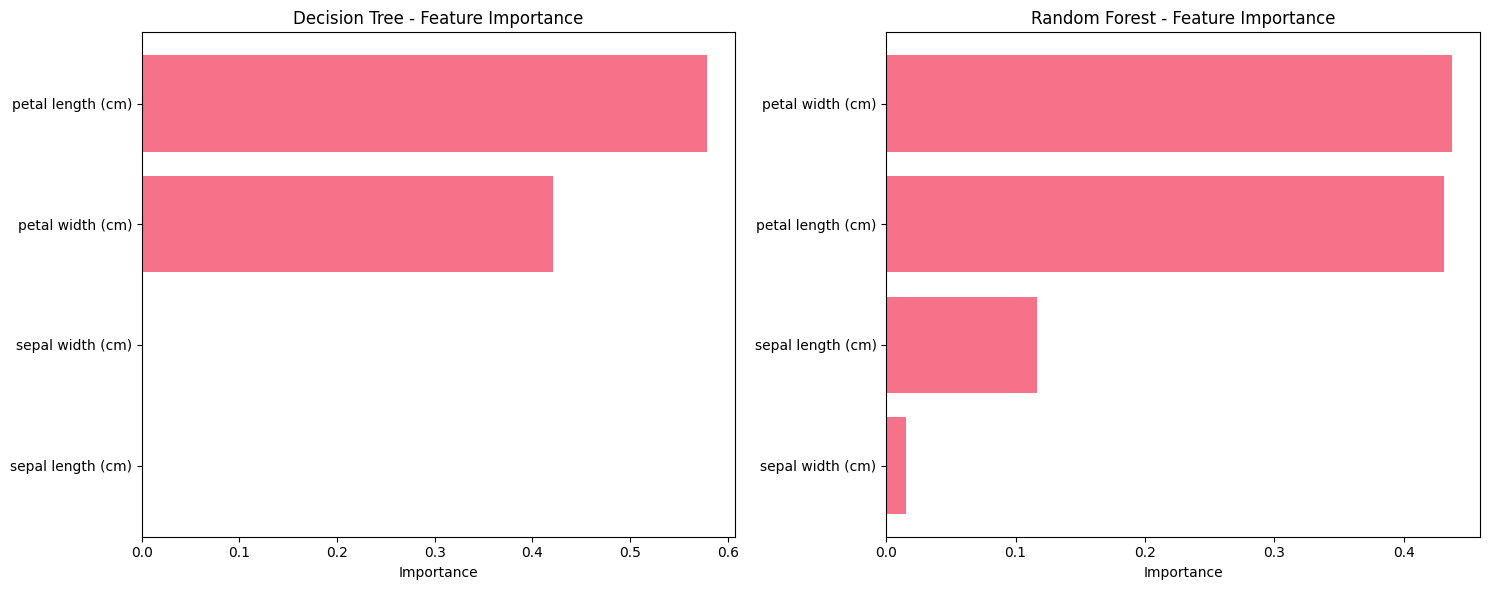


MODEL COMPARISON SUMMARY:
----------------------------------------
Logistic Regression  | Accuracy: 0.9333
SVM (RBF)            | Accuracy: 0.9667
Decision Tree        | Accuracy: 0.9667
Random Forest        | Accuracy: 0.9000

Best Model: SVM (RBF) with accuracy 0.9667


In [12]:
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, target_names=None):
    """Train and evaluate a classification model"""

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Use provided target_names or generate default ones
    if target_names is None:
        # Generate default target names based on unique classes
        unique_classes = np.unique(y_test)
        target_names = [f'Class {cls}' for cls in unique_classes]

    class_report = classification_report(y_test, y_pred, target_names=target_names)

    # ROC curve data if probabilities are available and it's a binary classification
    roc_auc = None
    if y_pred_proba is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }

# Split iris data
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)

# Scale iris data
iris_scaler = StandardScaler()
X_iris_train_scaled = iris_scaler.fit_transform(X_iris_train)
X_iris_test_scaled = iris_scaler.transform(X_iris_test)

# Train models on iris dataset
iris_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=3),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

iris_results = []
for model_name, model in iris_models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name} on Iris dataset...")
    print('='*50)

    # Pass iris_target_names specifically for this dataset
    result = train_and_evaluate_model(model, model_name, X_iris_train_scaled,
                                   X_iris_test_scaled, y_iris_train, y_iris_test,
                                   target_names=iris_target_names)
    iris_results.append(result)

    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"\nClassification Report:\n{result['classification_report']}")

# Plot iris results comparison with confusion matrices
def plot_iris_results(iris_results, target_names):
    """Plot results for iris dataset"""

    # Plot 1: Accuracy comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    model_names = [result['name'] for result in iris_results]
    accuracies = [result['accuracy'] for result in iris_results]

    bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Performance on Iris Dataset')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom')
    plt.grid(True, alpha=0.3)

    # Plot 2: Confusion matrices in a grid
    plt.subplot(1, 2, 2)
    # For simplicity, show the best model's confusion matrix
    best_model_idx = np.argmax(accuracies)
    best_result = iris_results[best_model_idx]

    conf_matrix = best_result['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{best_result["name"]} - Confusion Matrix\n(Best Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Plot all confusion matrices in a separate figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, result in enumerate(iris_results):
        if i < len(axes):
            conf_matrix = result['confusion_matrix']
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                       xticklabels=target_names, yticklabels=target_names, ax=axes[i])
            axes[i].set_title(f'{result["name"]} - Confusion Matrix')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot iris results
plot_iris_results(iris_results, iris_target_names)

# Additional analysis for iris dataset
print("\n" + "="*60)
print("IRIS DATASET - ADDITIONAL ANALYSIS")
print("="*60)

# Feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Decision Tree feature importance
dt_model = iris_results[2]['model']  # Decision Tree
dt_importance = dt_model.feature_importances_
sorted_idx_dt = np.argsort(dt_importance)

axes[0].barh(range(len(dt_importance)), dt_importance[sorted_idx_dt])
axes[0].set_yticks(range(len(dt_importance)))
axes[0].set_yticklabels([iris_feature_names[i] for i in sorted_idx_dt])
axes[0].set_title('Decision Tree - Feature Importance')
axes[0].set_xlabel('Importance')

# Random Forest feature importance
rf_model = iris_results[3]['model']  # Random Forest
rf_importance = rf_model.feature_importances_
sorted_idx_rf = np.argsort(rf_importance)

axes[1].barh(range(len(rf_importance)), rf_importance[sorted_idx_rf])
axes[1].set_yticks(range(len(rf_importance)))
axes[1].set_yticklabels([iris_feature_names[i] for i in sorted_idx_rf])
axes[1].set_title('Random Forest - Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Model comparison summary
print("\nMODEL COMPARISON SUMMARY:")
print("-" * 40)
for result in iris_results:
    print(f"{result['name']:20} | Accuracy: {result['accuracy']:.4f}")

best_model_idx = np.argmax([result['accuracy'] for result in iris_results])
best_model = iris_results[best_model_idx]
print(f"\nBest Model: {best_model['name']} with accuracy {best_model['accuracy']:.4f}")

In [13]:
def load_custom_dataset(dataset_path):
    """Template function for loading custom datasets"""
    # This is a template - implement based on your specific dataset
    # For CSV files:
    # df = pd.read_csv(dataset_path)
    # X = df.drop('target_column', axis=1).values
    # y = df['target_column'].values
    # feature_names = df.drop('target_column', axis=1).columns.tolist()
    # target_names = sorted(df['target_column'].unique())

    pass

def full_classification_pipeline(X, y, feature_names, target_names, dataset_name="Custom Dataset"):
    """Complete pipeline for any classification dataset"""

    print(f"\n{'='*60}")
    print(f"ANALYZING: {dataset_name}")
    print('='*60)

    # Data split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(kernel='rbf', random_state=42, probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    # Training and evaluation
    results = []
    for model_name, model in models.items():
        result = train_and_evaluate_model(model, model_name, X_train_scaled,
                                       X_test_scaled, y_train, y_test)
        results.append(result)
        print(f"{model_name}: Accuracy = {result['accuracy']:.4f}")

    return results

# Example usage for custom datasets:
# custom_results = full_classification_pipeline(X_custom, y_custom,
#                                            feature_names_custom,
#                                             target_names_custom,
#                                             "My Custom Dataset")